# Language Classification Using Machine Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler  
import joblib
import os

In [2]:
df=pd.read_csv('../data/Language Detection.csv')
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


## About the Dataset

In [3]:
print("dataset shape",df.shape)
print("dataset info\n",df.info())
print("missing values\n", df.isnull().sum())

dataset shape (10337, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB
dataset info
 None
missing values
 Text        0
Language    0
dtype: int64


## Distribution of Languages in Dataset

In [4]:
unique_languages=df["Language"].nunique()
print("Total unique languages are ",unique_languages)

language_counts=df["Language"].value_counts()
print("Language distribution\n",language_counts)

Total unique languages are  17
Language distribution
 Language
English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: count, dtype: int64


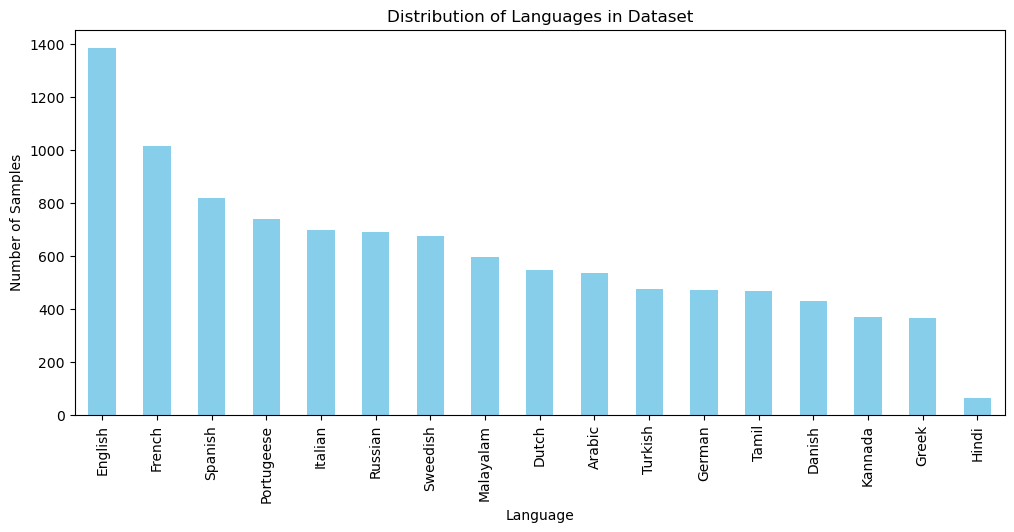

In [5]:
plt.figure(figsize=(12, 5))  # Set figure size
language_counts.plot(kind="bar", color="skyblue")  # Bar plot
plt.title("Distribution of Languages in Dataset")  # Title of the plot
plt.xlabel("Language")  # X-axis label
plt.ylabel("Number of Samples")  # Y-axis label
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()  # Display the plot

## Data Preprocessing

In [6]:
# Convert categorical language labels into numerical
le=LabelEncoder()
df["Language_Encoded"]=le.fit_transform(df["Language"])
label_mapping=dict(zip(le.classes_,le.transform(le.classes_)))
print("Label Mapping\n",label_mapping)

Label Mapping
 {'Arabic': 0, 'Danish': 1, 'Dutch': 2, 'English': 3, 'French': 4, 'German': 5, 'Greek': 6, 'Hindi': 7, 'Italian': 8, 'Kannada': 9, 'Malayalam': 10, 'Portugeese': 11, 'Russian': 12, 'Spanish': 13, 'Sweedish': 14, 'Tamil': 15, 'Turkish': 16}


In [7]:
nltk.download('stopwords')
nltk.download('punkt')

stemmer=PorterStemmer()
stop_words=set(stopwords.words('english'))

def preprocess_text(text):
    text=text.lower()
    text=re.sub(r'\d+','',text)
    text=text.translate(str.maketrans('','',string.punctuation))
    words=word_tokenize(text)
    words=[word for word in words if word not in stop_words]
    #words=[stemmer.stem(word) for word in words]
    
    return ''.join(words)

df["Processed_Text"]=df["Text"].apply(preprocess_text)


print(df[["Text","Processed_Text"]].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                Text  \
0   Nature, in the broadest sense, is the natural...   
1  "Nature" can refer to the phenomena of the phy...   
2  The study of nature is a large, if not the onl...   
3  Although humans are part of nature, human acti...   
4  [1] The word nature is borrowed from the Old F...   

                                      Processed_Text  
0  naturebroadestsensenaturalphysicalmaterialworl...  
1   naturereferphenomenaphysicalworldalsolifegeneral  
2                        studynaturelargepartscience  
3  althoughhumanspartnaturehumanactivityoftenunde...  
4  wordnatureborrowedoldfrenchnaturederivedlatinw...  


## Feature Extraction

In [8]:
# Create a TF-IDF vectorizer
vectorizer =TfidfVectorizer(max_features=10000,ngram_range=(1, 2), analyzer='char')  
# Limiting features to 5000 for efficiency
X = vectorizer.fit_transform(df["Processed_Text"]).toarray()

## Model Training

In [9]:
# Define target variable (encoded language labels)
y = df["Language_Encoded"]


# Check new class distribution
#print("New Class Distribution:", Counter(y_resampled))

#Split resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Initialize and train the Logistic Regression model
model=MultinomialNB()
model.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

## Model Evaluation

In [10]:
# Make predictions
y_pred = model.predict(X_test)
print("Unique predictions:", np.unique(y_pred, return_counts=True))
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Detailed performance report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Unique predictions: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), array([109,  81, 117, 263, 208,  93,  73,  12, 147,  74, 119, 148, 136,
       165, 135,  94,  94], dtype=int64))
Model Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       107
           1       0.99      0.93      0.96        86
           2       0.87      0.94      0.90       109
           3       0.94      0.90      0.92       277
           4       0.95      0.98      0.96       203
           5       0.96      0.95      0.95        94
           6       1.00      1.00      1.00        73
           7       1.00      1.00      1.00        12
           8       0.90      0.94      0.92       140
           9       1.00      1.00      1.00        74
          10       1.00      1.00      1.00       119
          11       0.97      0.97      0.97       148
          12       1.00      0.99      

## Saving the Model
- Saving the trained model and vectorizer

In [11]:
os.makedirs("models", exist_ok=True)
# Save trained model
joblib.dump(model, "models/language_classifier.pkl")
# Save TF-IDF vectorizer
joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


## Making Predictions

In [12]:
# Load the saved model and vectorizer
loaded_model = joblib.load("language_classifier.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Sample text input
new_texts = ["Bonjour, comment ça va ?", "Hola, ¿cómo estás?", "Das ist ein Beispiel."]

# Convert text into numerical format
new_texts_transformed = loaded_vectorizer.transform(new_texts).toarray()

# Predict the language
predictions = loaded_model.predict(new_texts_transformed)

print("Predicted Language Encodings:", predictions)
print("Decoded Languages:", [le.inverse_transform([p])[0] for p in predictions])


FileNotFoundError: [Errno 2] No such file or directory: 'language_classifier.pkl'